In [0]:
%matplotlib inline
!git clone https://github.com/MaelSa/datasets.git

import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from torchvision.datasets import MNIST
import torchvision.datasets as dset
import os
import numpy as np
import matplotlib.pyplot as plt

Cloning into 'datasets'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 10204 (delta 0), reused 4 (delta 0), pack-reused 10200
Receiving objects: 100% (10204/10204), 326.57 MiB | 13.00 MiB/s, done.
Checking out files: 100% (10194/10194), done.


In [0]:
if not os.path.exists('./dc_img'):
    os.mkdir('./dc_img')


def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 3, 256, 256)
    return x


num_epochs = 100
batch_size = 128
learning_rate = 1e-3

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataroot = "datasets/real"

dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               #transforms.Grayscale(num_output_channels=1),
                               #transforms.RandomRotation(180),
                               transforms.Resize(256),
                               transforms.CenterCrop(256),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                      
                           ]))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [0]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=3, padding=1),  # b, 16, 10, 10
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2),  # b, 16, 5, 5
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  # b, 8, 15, 15
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 3, 2, stride=2, padding=1),  # b, 1, 28, 28
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [0]:
model = autoencoder().cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                             weight_decay=1e-5)

In [0]:
loss_list = []
for epoch in range(num_epochs):
    for data in dataloader:
        img, _ = data
        img = Variable(img).cuda()
        # ===================forward=====================
        output = model(img)
        loss = criterion(output, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
        loss_list.append(loss.item())
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, loss.item()))
    pic = to_img(output.cpu().data)
    save_image(pic, './dc_img/image_{}.png'.format(epoch))




epoch [1/100], loss:0.1815
epoch [2/100], loss:0.1846
epoch [3/100], loss:0.1826
epoch [4/100], loss:0.1640
epoch [5/100], loss:0.1682
epoch [6/100], loss:0.1634
epoch [7/100], loss:0.1613
epoch [8/100], loss:0.1849
epoch [9/100], loss:0.1887
epoch [10/100], loss:0.1562
epoch [11/100], loss:0.1604
epoch [12/100], loss:0.1587
epoch [13/100], loss:0.1567
epoch [14/100], loss:0.1471
epoch [15/100], loss:0.1477
epoch [16/100], loss:0.1497
epoch [17/100], loss:0.1589
epoch [18/100], loss:0.1391
epoch [19/100], loss:0.1530
epoch [20/100], loss:0.1346
epoch [21/100], loss:0.1311
epoch [22/100], loss:0.1415
epoch [23/100], loss:0.1293
epoch [24/100], loss:0.1194
epoch [25/100], loss:0.1183
epoch [26/100], loss:0.1026
epoch [27/100], loss:0.1065
epoch [28/100], loss:0.1132
epoch [29/100], loss:0.1053
epoch [30/100], loss:0.0927
epoch [31/100], loss:0.0892
epoch [32/100], loss:0.0793
epoch [33/100], loss:0.0842
epoch [34/100], loss:0.0748
epoch [35/100], loss:0.0731
epoch [36/100], loss:0.0700
e

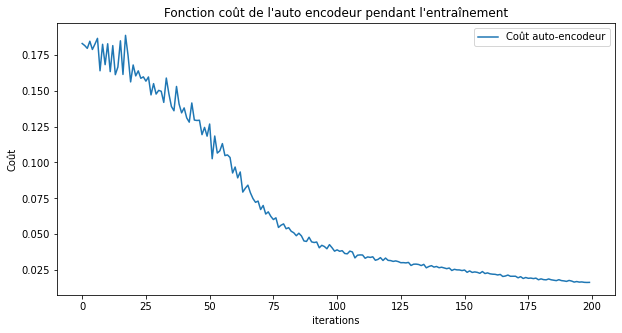

In [0]:
plt.figure(figsize=(10,5))
plt.title("Fonction coût de l'auto encodeur pendant l'entraînement")
plt.plot(loss_list,label="Coût auto-encodeur")
plt.xlabel("iterations")
plt.ylabel("Coût")
plt.legend()
plt.show()

In [0]:
torch.save(model.state_dict(), './conv_autoencoder.pth')